In [2]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import metrics


import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("covid_data.csv")

In [4]:
dftoDrop = df[df['iso_code'].str.match('OWID*')]
df_new = df.merge(dftoDrop, how='left', indicator=True)
df = df_new[df_new['_merge'] == 'left_only']

## Listing All the Variables

In [5]:
print(df.shape)
variables = list(df.columns)
print(f"{variables} variables")

(219559, 68)
['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hund

## Dealing with Missing Values

In [6]:
df = df.fillna(value = 0) #fill with zero
df.isnull().sum().sum()

0

## Get the Correlation Matrix

In [7]:
corrMatrix = df.corr()

In [8]:
deathRateCol = corrMatrix['total_deaths'] 
columnsToExplore = deathRateCol[abs(corrMatrix['total_deaths']) > 0.5]
print("Column to explore", len(columnsToExplore))
columnsToExplore

Column to explore 6


total_cases                0.891781
total_deaths               1.000000
new_deaths_smoothed        0.516226
total_tests                0.550874
people_vaccinated          0.561458
people_fully_vaccinated    0.522251
Name: total_deaths, dtype: float64

In [9]:
indexList = columnsToExplore.index.values.tolist() #variables that might be useful

In [10]:
for i in range(len(indexList)):              #get rid of rows with 0 entry for the prospective predictors
    df = df[df[indexList[i]] != 0]
df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,_merge
2370,ALB,Europe,Albania,2021-02-02,79934.0,942.0,891.857,1398.0,5.0,9.429,...,0.000,2.89,78.57,0.795,2842318.0,0.0,0.0,0.0,0.0,left_only
2377,ALB,Europe,Albania,2021-02-09,87528.0,1239.0,1084.857,1488.0,16.0,12.857,...,0.000,2.89,78.57,0.795,2842318.0,0.0,0.0,0.0,0.0,left_only
2385,ALB,Europe,Albania,2021-02-17,95726.0,1075.0,1007.857,1600.0,18.0,13.857,...,0.000,2.89,78.57,0.795,2842318.0,0.0,0.0,0.0,0.0,left_only
2386,ALB,Europe,Albania,2021-02-18,96838.0,1112.0,1008.857,1617.0,17.0,14.286,...,0.000,2.89,78.57,0.795,2842318.0,0.0,0.0,0.0,0.0,left_only
2390,ALB,Europe,Albania,2021-02-22,101285.0,1039.0,1062.143,1681.0,15.0,16.286,...,0.000,2.89,78.57,0.795,2842318.0,0.0,0.0,0.0,0.0,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238058,ZWE,Africa,Zimbabwe,2022-06-05,253338.0,102.0,178.000,5510.0,1.0,1.429,...,36.791,1.70,61.49,0.571,16320539.0,0.0,0.0,0.0,0.0,left_only
238061,ZWE,Africa,Zimbabwe,2022-06-08,253779.0,142.0,129.286,5515.0,0.0,1.143,...,36.791,1.70,61.49,0.571,16320539.0,0.0,0.0,0.0,0.0,left_only
238065,ZWE,Africa,Zimbabwe,2022-06-12,254098.0,67.0,108.571,5521.0,3.0,1.571,...,36.791,1.70,61.49,0.571,16320539.0,0.0,0.0,0.0,0.0,left_only
238069,ZWE,Africa,Zimbabwe,2022-06-16,254502.0,115.0,103.286,5526.0,1.0,1.571,...,36.791,1.70,61.49,0.571,16320539.0,0.0,0.0,0.0,0.0,left_only


In [11]:
corrMatrix2 = df.corr()#update the correlation matrix
deathRateCol2 = corrMatrix2['total_deaths'] 
columnsToExplore2 = deathRateCol2[abs(corrMatrix2['total_deaths']) >0.5]
print("Column to explore", len(columnsToExplore2))
columnsToExplore2

Column to explore 16


total_cases                  0.919755
total_deaths                 1.000000
new_deaths                   0.570806
new_deaths_smoothed          0.616168
icu_patients                 0.540500
hosp_patients                0.544404
weekly_hosp_admissions       0.564740
total_tests                  0.853740
new_tests                    0.541060
new_tests_smoothed           0.681367
total_vaccinations           0.638795
people_vaccinated            0.622674
people_fully_vaccinated      0.610315
total_boosters               0.537158
new_vaccinations_smoothed    0.516229
population                   0.585456
Name: total_deaths, dtype: float64

## Doing a Multiple Linear Regression

In [12]:
X = df[["population","total_boosters", "total_vaccinations", "total_tests","weekly_hosp_admissions", "total_cases", "icu_patients"]]
Y = df[["total_deaths"]]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

## Normalization

In [14]:
x_scaler = preprocessing.StandardScaler().fit(X_train)
X_train = x_scaler.transform(X_train)

y_scaler = preprocessing.StandardScaler().fit(y_train)
y_train = y_scaler.transform(y_train)

## Model Training

In [15]:
model1=LinearRegression()
model1.fit(X_train , y_train)
y_pred= model1.predict(X_train)

## Model Testing: Training Data

In [16]:
MSE = metrics.mean_squared_error(y_train, y_pred)
RMSE = np.sqrt(MSE)
pd.DataFrame([MSE, RMSE], index=['MSE', 'RMSE'], columns=['Metrics'])

,Metrics
MSE,0.116259
RMSE,0.340967


In [17]:
metrics.r2_score(y_train, y_pred)

0.8837413541623901

## Model Testing: Testing Data

In [18]:
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)
y_pred= model1.predict(X_test)

In [19]:
MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
pd.DataFrame([MSE, RMSE], index=['MSE', 'RMSE'], columns=['Metrics'])

,Metrics
MSE,0.113402
RMSE,0.336752


In [20]:
metrics.r2_score(y_test, y_pred)

0.8740871136734586

##  Plots

min(X_train[:, 0])

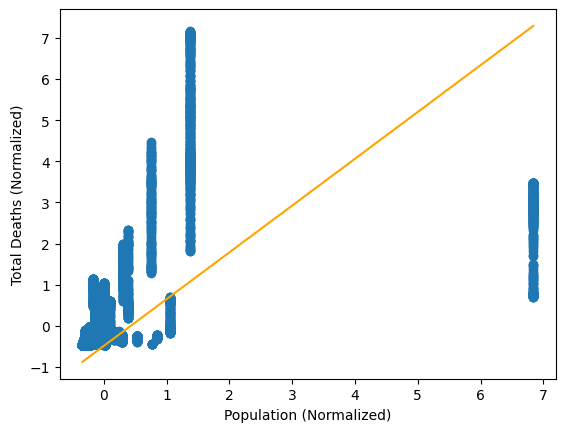

In [35]:
y_pred= model1.predict(X_train)
plt.scatter(X_train[:, 0], y_train)
plt.plot([min(X_train[:, 0]), max(X_train[:, 0])], [min(y_pred), max(y_pred)],
         color="orange");
plt.xlabel("Population (Normalized)")
plt.ylabel("Total Deaths (Normalized)");


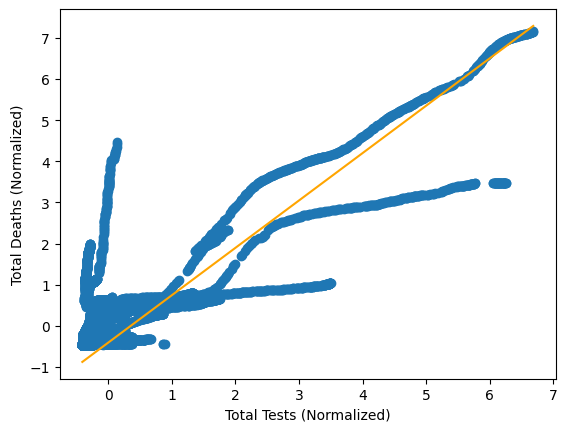

In [41]:
plt.scatter(X_train[:, 3], y_train)
plt.plot([min(X_train[:, 3]), max(X_train[:, 3])], [min(y_pred), max(y_pred)],
         color="orange");
plt.xlabel("Total Tests (Normalized)")
plt.ylabel("Total Deaths (Normalized)");